Chuẩn hóa lại các giá trị về dinh dưỡng: Calories,.... Mặc dù model chính của mình dùng Random Forest - không yêu cầu chuẩn hóa, nhưng để đề phòng thêm các model khác thì tiện tay chuẩn hóa luôn, chọn chuẩn hóa min-max

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df = pd.read_csv('D:/ML_2/Final_Recipe_Rec/final_fin_dataset.csv')

Drop đi mấy cột classification trước nhét vào đi, để thêm lại các cột sau khi chỉnh hôm 8/6

In [2]:
# List of columns you want to drop
cols_to_drop = [
    'Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic',
    'Hypertension', 'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb'
]

# Drop only those columns that actually exist in df
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])


In [3]:
nutrition_cols = ['Calories', 'Fat', 'Saturates', 'Carbs', 'Protein', 'Fibre', 'Sugars', 'Salt']

df[nutrition_cols].isnull().sum()
scaler = MinMaxScaler()
df[nutrition_cols] = scaler.fit_transform(df[nutrition_cols])
print(f'Giá trị sau khi chuẩn hóa: \n{df[nutrition_cols].head()}')

Giá trị sau khi chuẩn hóa: 
   Calories       Fat  Saturates     Carbs   Protein     Fibre    Sugars  \
0  0.106719  0.083502   0.085492  0.000000  0.140159  0.000000  0.000000   
1  0.347826  0.146128   0.119171  0.284625  0.359841  0.134615  0.055351   
2  0.218709  0.079461   0.095855  0.207751  0.239563  0.000000  0.026753   
3  0.101449  0.053199   0.067358  0.125159  0.027833  0.033654  0.042435   
4  0.251647  0.111111   0.072539  0.202668  0.248509  0.000000  0.013838   

    Salt  
0  0.141  
1  0.290  
2  0.000  
3  0.020  
4  0.000  


Mã hóa lại các cột Cook Time, Difficulty

- Label Encoding: Mã hóa độ khó super easy thành 0, not too tricky thành 1 nhưng mà không nên dùng kiểu này vì việc mã hóa bằng số nguyên có thể khiến mô hình hiểu lầm rằng Showing Off quan trọng hơn Super Easy, dù thực tế chỉ là một danh mục phân loại. Mặc dù RF hoàn toàn có thể xử lý label nhưng mà vẫn nên chọn one-hot encoding để làm 'bảo hiểm'

- One-hot encoding: Mã hóa các giá trị unique thành các cột mới chứa giá trị nhị phân

In [4]:
df = pd.get_dummies(df, columns=['Difficulty'])
print(df[['Difficulty_NOT TOO TRICKY', 'Difficulty_SHOWING OFF', 'Difficulty_SUPER EASY']].head())


   Difficulty_NOT TOO TRICKY  Difficulty_SHOWING OFF  Difficulty_SUPER EASY
0                       True                   False                  False
1                      False                   False                   True
2                      False                   False                   True
3                      False                    True                  False
4                       True                   False                  False


In [6]:
import re

def cook_time_to_minutes(cook_time):

    # Chuyển về string và uppercase để xử lý nhất quán
    cook_time = str(cook_time).upper().strip()
    
    # Bỏ qua phần trong dấu ngoặc
    cook_time = re.sub(r'\(.*?\)', '', cook_time).strip()
    
    time_in_minutes = 0
    
    # Tìm số giờ và phút trong chuỗi (nhận HR hoặc HRS)
    match = re.search(r'(\d+)\s*(HR|HRS).*?(\d+)\s*MINS?', cook_time)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(3))
        time_in_minutes = hours * 60 + minutes
    else:
        # Tìm chỉ giờ (không có phút)
        match = re.search(r'(\d+)\s*(HR|HRS)', cook_time)
        if match:
            hours = int(match.group(1))
            time_in_minutes = hours * 60
        else:
            # Nếu chỉ có phút
            match = re.search(r'(\d+)\s*MINS?', cook_time)
            if match:
                time_in_minutes = int(match.group(1))
    
    return time_in_minutes

# 2. Áp dụng hàm để tính tổng phút cho cột 'Cook Time'
df['Cook Time (Minutes)'] = df['Cook Time'].apply(cook_time_to_minutes)

# 3. Phân nhóm thời gian nấu (Cook Time) thành các nhóm
def encode_cook_time(cook_time):
    if cook_time < 15:
        return 'Under 15 mins'
    elif 15 <= cook_time < 30:
        return '15 to 30 mins'
    elif 30 <= cook_time < 70:
        return '30 to 70 mins'
    elif 70 <= cook_time < 100:
        return '70 to 100 mins'
    elif 100 <= cook_time < 200:
        return '100 to 200 mins'
    else:
        return 'Over 200 mins'

# Áp dụng hàm phân nhóm thời gian nấu vào cột mới
df['Cook Time Group'] = df['Cook Time (Minutes)'].apply(encode_cook_time)

#  One-Hot Encoding lên 'Cook Time Group'
cook_time_encoded = pd.get_dummies(df['Cook Time Group'], prefix='Cook Time Group')
df = pd.concat([df, cook_time_encoded], axis=1)


# 5. Kiểm tra kết quả
print("Cook Time processing completed!")
print(f"Shape of dataframe: {df.shape}")
print("\nSample data:")

# Lấy các cột có liên quan để hiển thị
cook_time_cols = [col for col in df.columns if 'Cook Time' in col]
if len(cook_time_cols) > 0:
    print(df[cook_time_cols].head())
else:
    print("No Cook Time columns found")

# Hiển thị thống kê phân phối thời gian nấu
print(f"\nCook Time Statistics:")
print(df['Cook Time (Minutes)'].describe())

print(f"\nCook Time Group Distribution:")
if 'Cook Time Group' in df.columns:
    print(df['Cook Time Group'].value_counts())

Cook Time processing completed!
Shape of dataframe: (3161, 705)

Sample data:
      Cook Time  Cook Time (Minutes) Cook Time Group  \
0       10 MINS                   10   Under 15 mins   
1       30 MINS                   30   30 to 70 mins   
2       20 MINS                   20   15 to 30 mins   
3  1 HR 30 MINS                   90  70 to 100 mins   
4  1 HR 30 MINS                   90  70 to 100 mins   

   Cook Time Group_100 to 200 mins  Cook Time Group_100 to 200 mins  \
0                            False                            False   
1                            False                            False   
2                            False                            False   
3                            False                            False   
4                            False                            False   

   Cook Time Group_15 to 30 mins  Cook Time Group_15 to 30 mins  \
0                          False                          False   
1                       

Chắc quá trình chạy lại code lỗi gì đó nên là count thành 3161 rồi =))

In [7]:
# Xoá các món trùng tên, giữ lại bản xuất hiện đầu tiên
rows_before = df.shape[0]

df = df.drop_duplicates(subset=['Dish Name'], keep='first').reset_index(drop=True)

rows_after  = df.shape[0]
print(f"Đã xoá {rows_before - rows_after} dòng trùng. Dataset giờ còn {rows_after} món ăn 🤙")


Đã xoá 41 dòng trùng. Dataset giờ còn 3120 món ăn 🤙


In [8]:
df.drop(columns=['Cook Time', 'Cook Time Group'], inplace=True)
df.head(3)


,Dish Name,Ingredients,Method,About,Main Ingredient,Calories,Fat,Saturates,Sugars,Salt,...,Cook Time Group_30 to 70 mins,Cook Time Group_70 to 100 mins,Cook Time Group_Over 200 mins,Cook Time Group_Under 15 mins,Cook Time Group_100 to 200 mins,Cook Time Group_15 to 30 mins,Cook Time Group_30 to 70 mins,Cook Time Group_70 to 100 mins,Cook Time Group_Over 200 mins,Cook Time Group_Under 15 mins
0,POACHED EGGS,4 large free-range eggs,Half-fill a wide pan with boiling salted water...,"Perfect poached eggs are a real joy, and easie...",Eggs,0.106719,0.083502,0.085492,0.000000,0.141,...,False,False,False,True,False,False,False,False,False,True
1,CREAMY MUSSELS WITH SMOKY BACON & CIDER,1 clove of garlic|½ a bunch fresh of flat-leaf...,"Peel and finely slice the garlic, pick and rou...",This boozy mussels recipe makes the most amazi...,Seafood,0.347826,0.146128,0.119171,0.055351,0.290,...,True,False,False,False,False,False,True,False,False,False
2,ASPARAGUS & CRAB LINGUINE,500g dried linguine|1 fresh red chilli|1 large...,Cook the pasta in a large pan of boiling salte...,"A super-easy, fresh midweek supper by Georgina...",Pasta,0.218709,0.079461,0.095855,0.026753,0.000,...,False,False,False,False,False,True,False,False,False,False


Giờ gộp lại file phân loại sau khi ae chỉnh hôm 8/6 nke


In [9]:
df1 = pd.read_csv('D:/ML_2/Final_Recipe_Rec/classreal.csv')
df1.head(3)

,Dish Name,Weight_Loss,Bodybuilder,Vegetarian,Low_Carb,Hypertension,Heart-Healthy Diet,Diabetic,CleanEating
0,POACHED EGGS,0,0,0,1,0,0,0,0
1,CREAMY MUSSELS WITH SMOKY BACON & CIDER,0,1,0,0,0,0,0,0
2,ASPARAGUS & CRAB LINGUINE,0,1,0,0,0,0,0,0


In [10]:
# Xoá các món trùng tên, giữ lại bản xuất hiện đầu tiên
rows_before = df1.shape[0]

df1 = df1.drop_duplicates(subset=['Dish Name'], keep='first').reset_index(drop=True)

rows_after  = df1.shape[0]
print(f"Đã xoá {rows_before - rows_after} dòng trùng. Dataset giờ còn {rows_after} món ăn 🤙")


Đã xoá 13 dòng trùng. Dataset giờ còn 3120 món ăn 🤙


In [11]:
#  Gộp vào df theo Dish Name
#   - how='left'  → giữ nguyên tất cả món ăn trong df
#   - suffixes     → tránh trùng tên cột (nếu 2 bảng có cột trùng nhau ngoài Dish Name)
merged_df = df.merge(df1,
                     on='Dish Name',
                     how='left',
                     suffixes=('', '_class'))
df = merged_df.reset_index(drop=True)
df.head(3)

,Dish Name,Ingredients,Method,About,Main Ingredient,Calories,Fat,Saturates,Sugars,Salt,...,Cook Time Group_Over 200 mins,Cook Time Group_Under 15 mins,Weight_Loss,Bodybuilder,Vegetarian,Low_Carb,Hypertension,Heart-Healthy Diet,Diabetic,CleanEating
0,POACHED EGGS,4 large free-range eggs,Half-fill a wide pan with boiling salted water...,"Perfect poached eggs are a real joy, and easie...",Eggs,0.106719,0.083502,0.085492,0.000000,0.141,...,False,True,0,0,0,1,0,0,0,0
1,CREAMY MUSSELS WITH SMOKY BACON & CIDER,1 clove of garlic|½ a bunch fresh of flat-leaf...,"Peel and finely slice the garlic, pick and rou...",This boozy mussels recipe makes the most amazi...,Seafood,0.347826,0.146128,0.119171,0.055351,0.290,...,False,False,0,1,0,0,0,0,0,0
2,ASPARAGUS & CRAB LINGUINE,500g dried linguine|1 fresh red chilli|1 large...,Cook the pasta in a large pan of boiling salte...,"A super-easy, fresh midweek supper by Georgina...",Pasta,0.218709,0.079461,0.095855,0.026753,0.000,...,False,False,0,1,0,0,0,0,0,0


In [12]:
# Xóa các cột không cần thiết cho model
df.drop(columns=['Method', 'Ingredients', 'About','Dish Name'], inplace=True)

df.head(3)


,Main Ingredient,Calories,Fat,Saturates,Sugars,Salt,Protein,Carbs,Fibre,acorn squash,...,Cook Time Group_Over 200 mins,Cook Time Group_Under 15 mins,Weight_Loss,Bodybuilder,Vegetarian,Low_Carb,Hypertension,Heart-Healthy Diet,Diabetic,CleanEating
0,Eggs,0.106719,0.083502,0.085492,0.000000,0.141,0.140159,0.000000,0.000000,0,...,False,True,0,0,0,1,0,0,0,0
1,Seafood,0.347826,0.146128,0.119171,0.055351,0.290,0.359841,0.284625,0.134615,0,...,False,False,0,1,0,0,0,0,0,0
2,Pasta,0.218709,0.079461,0.095855,0.026753,0.000,0.239563,0.207751,0.000000,0,...,False,False,0,1,0,0,0,0,0,0


Tiếp tục one-hot cho cột Main Ingredient

In [13]:
df = pd.get_dummies(df, columns=['Main Ingredient'], drop_first=True)
print(df[['Main Ingredient_Eggs', 'Main Ingredient_Seafood', 'Main Ingredient_Pasta', 'Main Ingredient_Bread', 'Main Ingredient_Fish']].head())


   Main Ingredient_Eggs  Main Ingredient_Seafood  Main Ingredient_Pasta  \
0                  True                    False                  False   
1                 False                     True                  False   
2                 False                    False                   True   
3                 False                    False                  False   
4                 False                    False                  False   

   Main Ingredient_Bread  Main Ingredient_Fish  
0                  False                 False  
1                  False                 False  
2                  False                 False  
3                   True                 False  
4                  False                  True  


In [14]:
# 1. Tạo dictionary để gộp các cặp giá trị tương đương
ingredient_mapping = {
    'Eggs': 'Egg',
    'Egg': 'Egg',
    'Pie And Pastry': 'Pie',
    'Pies Pastries': 'Pie',
    'Chicken Breast': 'Chicken',
    'Healthy Chicken': 'Chicken',
    'Chicken': 'Chicken',
    'Veget': 'Vegetables',
    'Veg': 'Vegetables',
}

# 2. Lấy danh sách các cột One-Hot Encoding của `Main Ingredient`
main_ingredient_cols = [col for col in df.columns if 'Main Ingredient' in col]

# 3. Duyệt qua từng cột One-Hot Encoding để gộp thông tin vào cột chính
for col in main_ingredient_cols:
    for key, value in ingredient_mapping.items():
        # Kiểm tra xem tên cột có chứa key từ ingredient_mapping
        if key in col:
            # Kiểm tra xem cột chính đã tồn tại chưa, nếu chưa tạo nó
            if value not in df.columns:
                df[value] = False  # Khởi tạo cột chính với giá trị False

            # Gộp giá trị True từ cột phụ vào cột chính (sử dụng toán tử OR)
            df[value] = df[value] | df[col]

            # Xóa cột phụ sau khi gộp
            df.drop(columns=[col], inplace=True)
            break  # Dừng vòng lặp khi đã gộp thành công cột này

# Kiểm tra kết quả
print(df.head())


   Calories       Fat  Saturates    Sugars   Salt   Protein     Carbs  \
0  0.106719  0.083502   0.085492  0.000000  0.141  0.140159  0.000000   
1  0.347826  0.146128   0.119171  0.055351  0.290  0.359841  0.284625   
2  0.218709  0.079461   0.095855  0.026753  0.000  0.239563  0.207751   
3  0.101449  0.053199   0.067358  0.042435  0.020  0.027833  0.125159   
4  0.251647  0.111111   0.072539  0.013838  0.000  0.248509  0.202668   

      Fibre  acorn squash  aioli  ...  Main Ingredient_Sweet Potato  \
0  0.000000             0      0  ...                         False   
1  0.134615             0      0  ...                         False   
2  0.000000             0      0  ...                         False   
3  0.033654             0      0  ...                         False   
4  0.000000             0      0  ...                         False   

   Main Ingredient_Sweets Recipes  Main Ingredient_Tofu  \
0                           False                 False   
1               

In [15]:
print(df.columns.tolist())

['Calories', 'Fat', 'Saturates', 'Sugars', 'Salt', 'Protein', 'Carbs', 'Fibre', 'acorn squash', 'aioli', 'ajo', 'ajwain', 'alcohol', 'ale', 'allspice', 'almonds', 'amaretti biscuits', 'amaretto', 'anchovies', 'anchovy fillets', 'andouille', 'angelica', 'anise', 'aniseed', 'aperol', 'apple', 'apricot', 'armagnac', 'arrabbiata sauce', 'artichoke', 'asafoetida', 'asparagus', 'aubergine', 'avocado', 'baby capers', 'baby leeks', 'bacon', 'bagel', 'baguette', 'baileys', 'banana', 'baps', 'barolo', 'basil', 'basmati rice', 'bay leaves', 'bean', 'beansprouts', 'beef', 'beef mince', 'beer', 'beetroot', 'beets', 'belly', 'berkswell', 'berries', 'biber', 'biscotti', 'biscuits', 'bitters', 'black olives', 'black peppercorns', 'blackberries', 'blancmange', 'bloomer', 'blueberries', 'bok choi', 'bologna', 'bolognese', 'borlotti beans', 'bourbon', 'bourguignon', 'brambles', 'bran', 'brandy', 'bread', 'bread flour', 'breadcrumbs', 'bream', 'bresaola', 'brie', 'briks', 'brisket', 'broad beans', 'brocco

Nhầm... phải là Main Ingredient_Egg thay vì Egg

In [16]:
all_columns = df.columns.tolist()

# Lọc 4 cột cuối
last_4_columns = all_columns[-4:]

# 2. Đổi tên các cột cuối
df.rename(columns={
    last_4_columns[0]: 'Main Ingredient_Chicken',
    last_4_columns[1]: 'Main Ingredient_Egg',
    last_4_columns[2]: 'Main Ingredient_Vegetable',
    last_4_columns[3]: 'Main Ingredient_Pie'
}, inplace=True)

# 3. Kiểm tra kết quả
print(df.head())

   Calories       Fat  Saturates    Sugars   Salt   Protein     Carbs  \
0  0.106719  0.083502   0.085492  0.000000  0.141  0.140159  0.000000   
1  0.347826  0.146128   0.119171  0.055351  0.290  0.359841  0.284625   
2  0.218709  0.079461   0.095855  0.026753  0.000  0.239563  0.207751   
3  0.101449  0.053199   0.067358  0.042435  0.020  0.027833  0.125159   
4  0.251647  0.111111   0.072539  0.013838  0.000  0.248509  0.202668   

      Fibre  acorn squash  aioli  ...  Main Ingredient_Sweet Potato  \
0  0.000000             0      0  ...                         False   
1  0.134615             0      0  ...                         False   
2  0.000000             0      0  ...                         False   
3  0.033654             0      0  ...                         False   
4  0.000000             0      0  ...                         False   

   Main Ingredient_Sweets Recipes  Main Ingredient_Tofu  \
0                           False                 False   
1               

Chuyển hết về dạng 0/1 cho đồng bộ

In [17]:
# Chuyển tất cả các giá trị True/False thành 1/0
df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Kiểm tra lại kết quả
print(df.head())


C:\Users\tlkur\AppData\Local\Temp\ipykernel_20400\3161910344.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))


   Calories       Fat  Saturates    Sugars   Salt   Protein     Carbs  \
0  0.106719  0.083502   0.085492  0.000000  0.141  0.140159  0.000000   
1  0.347826  0.146128   0.119171  0.055351  0.290  0.359841  0.284625   
2  0.218709  0.079461   0.095855  0.026753  0.000  0.239563  0.207751   
3  0.101449  0.053199   0.067358  0.042435  0.020  0.027833  0.125159   
4  0.251647  0.111111   0.072539  0.013838  0.000  0.248509  0.202668   

      Fibre  acorn squash  aioli  ...  Main Ingredient_Sweet Potato  \
0  0.000000             0      0  ...                             0   
1  0.134615             0      0  ...                             0   
2  0.000000             0      0  ...                             0   
3  0.033654             0      0  ...                             0   
4  0.000000             0      0  ...                             0   

   Main Ingredient_Sweets Recipes  Main Ingredient_Tofu  \
0                               0                     0   
1               

In [18]:
df.head(3)

,Calories,Fat,Saturates,Sugars,Salt,Protein,Carbs,Fibre,acorn squash,aioli,...,Main Ingredient_Sweet Potato,Main Ingredient_Sweets Recipes,Main Ingredient_Tofu,Main Ingredient_Tomato,Main Ingredient_Turkey,Main Ingredient_Venison,Main Ingredient_Chicken,Main Ingredient_Egg,Main Ingredient_Vegetable,Main Ingredient_Pie
0,0.106719,0.083502,0.085492,0.000000,0.141,0.140159,0.000000,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.347826,0.146128,0.119171,0.055351,0.290,0.359841,0.284625,0.134615,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.218709,0.079461,0.095855,0.026753,0.000,0.239563,0.207751,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0


+ Phân tích phân phối của các target columns như Weight_Loss, Bodybuilder, CleanEating, Diabetic, Hypertension, Heart-Healthy Diet, Vegetarian, Low_Carb.

+ Phân tích mối quan hệ giữa các target columns bằng heatmap (correlation matrix).

+ Phân tích phân phối của các tính năng (features) như Calories, Fat, Carbs, Protein...

Tạo cột None nếu món ăn đó không phù hợp với các label

In [19]:
# Tạo cột 'None' cho các món ăn không thuộc nhóm mục tiêu nào
def create_none_column(row):
    # Nếu tất cả các mục tiêu đều là 0, thì gán None = 1, ngược lại 0
    if all(row[target] == 0 for target in ['Weight_Loss', 'Bodybuilder', 'CleanEating', 
                                           'Diabetic', 'Hypertension', 'Heart-Healthy Diet', 
                                           'Vegetarian', 'Low_Carb']):
        return 1  # Món ăn không thuộc bất kỳ nhóm nào
    else:
        return 0  # Món ăn thuộc ít nhất một nhóm

# Áp dụng hàm để tạo cột 'None'
df['None'] = df.apply(create_none_column, axis=1)

print(df[['None', 'Weight_Loss', 'Bodybuilder', 'Diabetic', 'Vegetarian', 'Low_Carb']].head(3))


   None  Weight_Loss  Bodybuilder  Diabetic  Vegetarian  Low_Carb
0     0            0            0         0           0         1
1     0            0            1         0           0         0
2     0            0            1         0           0         0


Weight_Loss distribution:
Weight_Loss
0    2687
1     433
Name: count, dtype: int64
----------------------------------------
Bodybuilder distribution:
Bodybuilder
0    2516
1     604
Name: count, dtype: int64
----------------------------------------
CleanEating distribution:
CleanEating
0    2707
1     413
Name: count, dtype: int64
----------------------------------------
Diabetic distribution:
Diabetic
0    2808
1     312
Name: count, dtype: int64
----------------------------------------
Hypertension distribution:
Hypertension
0    2545
1     575
Name: count, dtype: int64
----------------------------------------
Heart-Healthy Diet distribution:
Heart-Healthy Diet
0    2819
1     301
Name: count, dtype: int64
----------------------------------------
Vegetarian distribution:
Vegetarian
0    2729
1     391
Name: count, dtype: int64
----------------------------------------
Low_Carb distribution:
Low_Carb
0    2580
1     540
Name: count, dtype: int64
---------------------------------------

C:\Users\tlkur\AppData\Local\Temp\ipykernel_20400\3526364223.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=target, palette='viridis', ax=axes[i])
C:\Users\tlkur\AppData\Local\Temp\ipykernel_20400\3526364223.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=target, palette='viridis', ax=axes[i])
C:\Users\tlkur\AppData\Local\Temp\ipykernel_20400\3526364223.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=target, palette='viridis', ax=axes[i])
C:\Users\tlkur\AppData\Local\Temp\ipykernel_20400

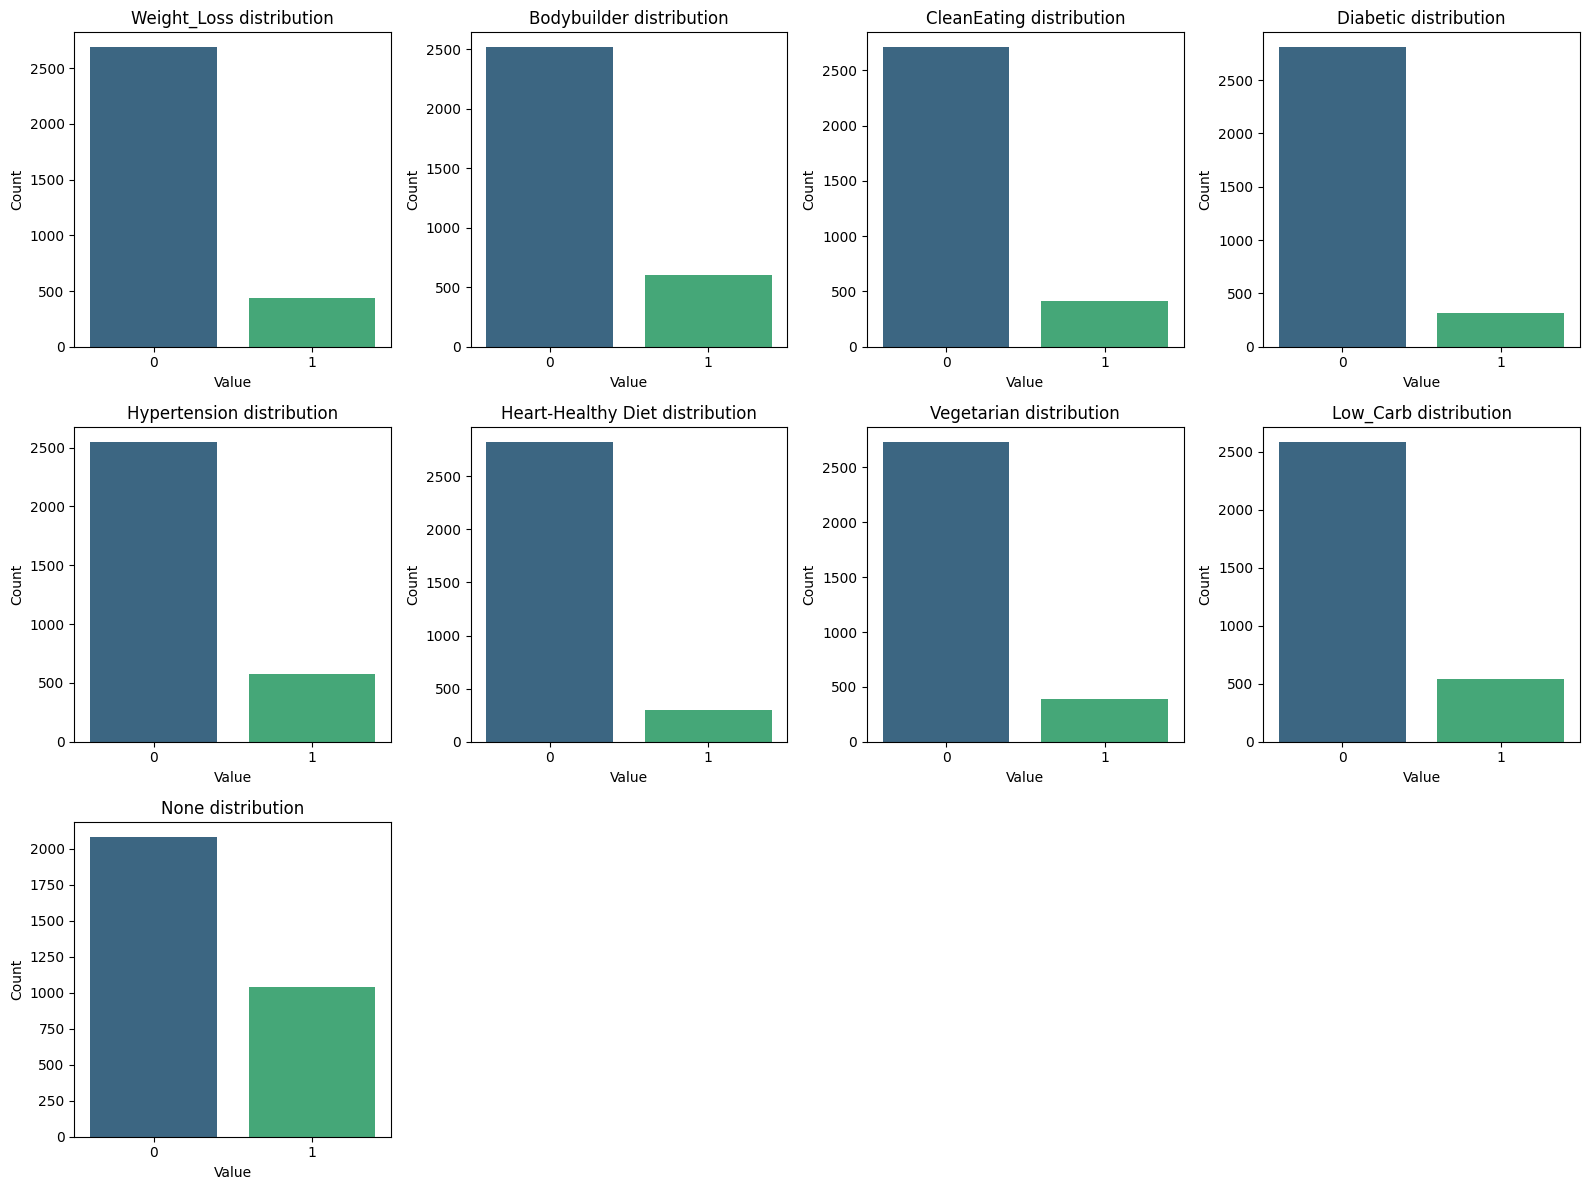

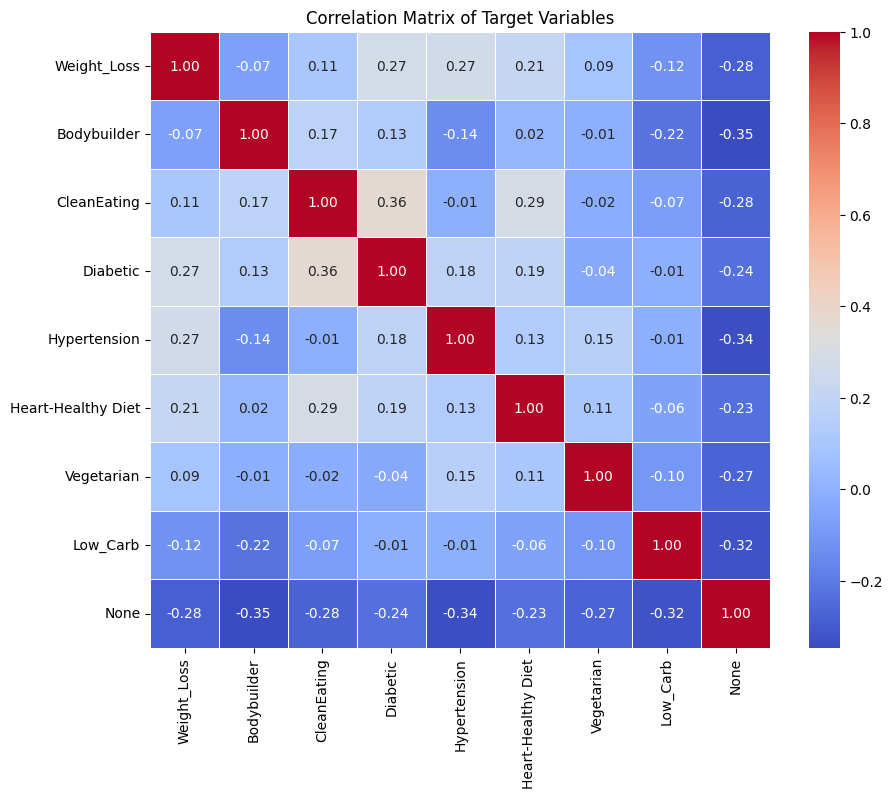


Descriptive statistics for nutrition columns:
          Calories          Fat    Saturates       Sugars         Salt  \
count  3120.000000  3120.000000  3120.000000  3120.000000  3120.000000   
mean      0.269192     0.129161     0.167347     0.106284     0.079978   
std       0.129320     0.083194     0.130536     0.104584     0.087110   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.178524     0.074074     0.075130     0.039437     0.000000   
50%       0.266798     0.115825     0.134715     0.075646     0.060000   
75%       0.350461     0.172391     0.231218     0.134686     0.130000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             Carbs      Protein        Fibre  
count  3120.000000  3120.000000  3120.000000  
mean      0.239377     0.209836     0.146862  
std       0.162290     0.157312     0.168054  
min       0.000000     0.000000     0.000000  
25%       0.108640     0.079523     0.000000  
50% 

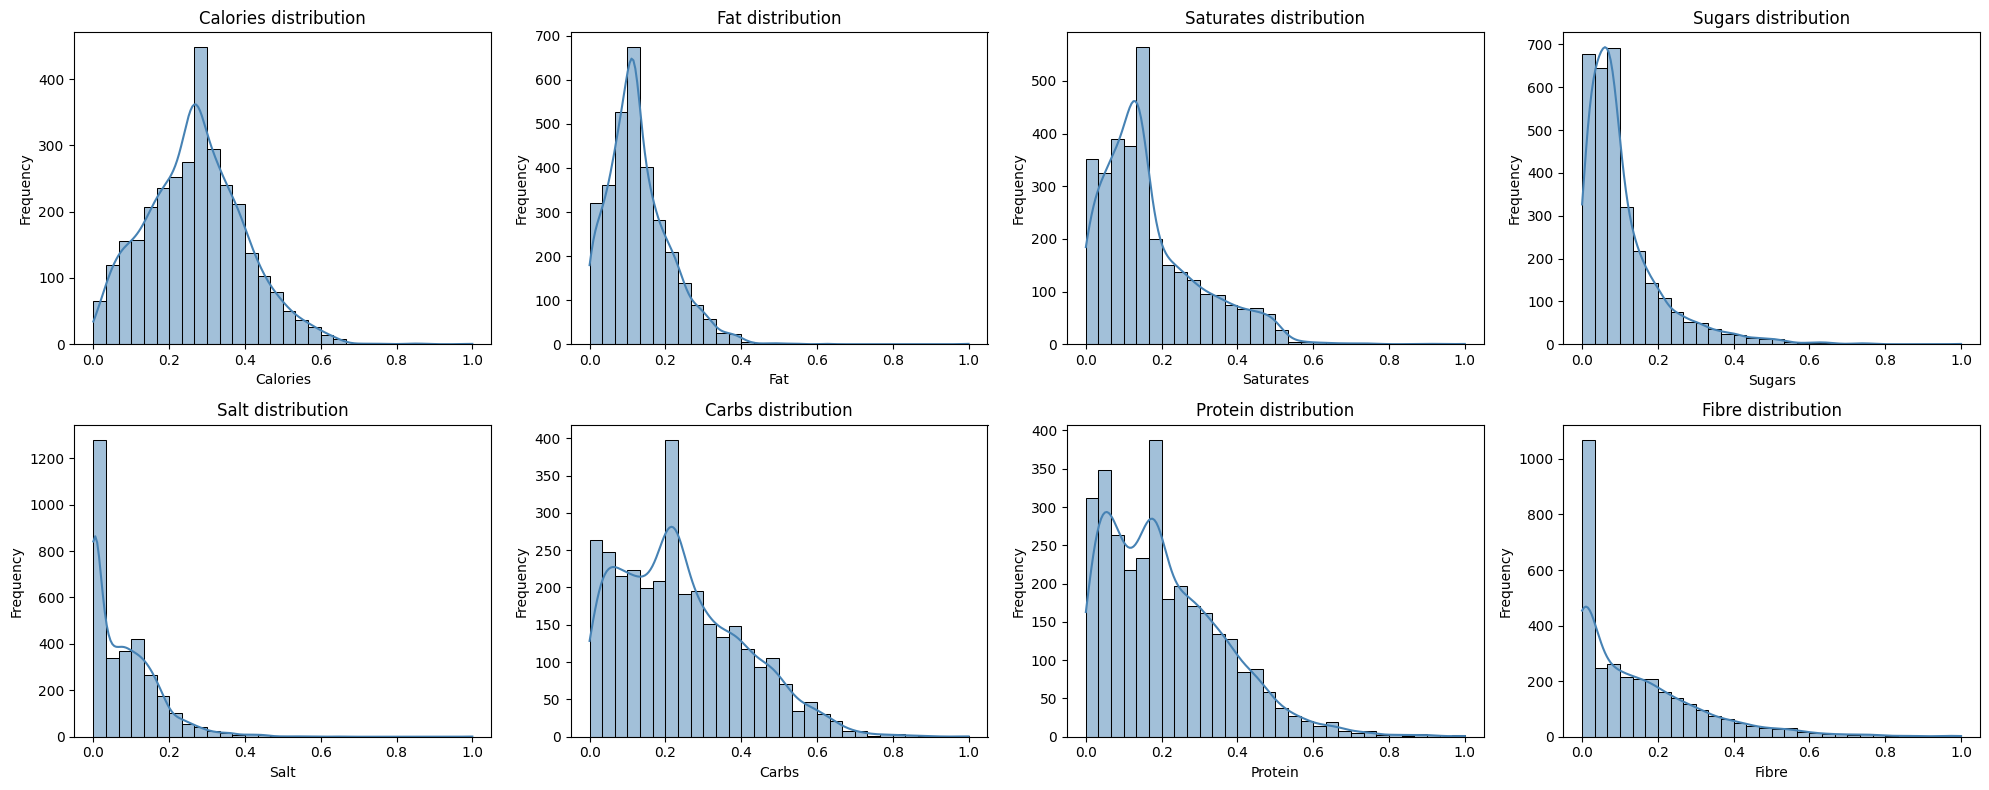

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math


# 1) PHÂN PHỐI CÁC LABEL
target_columns = [
    'Weight_Loss', 'Bodybuilder', 'CleanEating', 'Diabetic',
    'Hypertension', 'Heart-Healthy Diet', 'Vegetarian', 'Low_Carb', 'None'
]

for target in target_columns:
    print(f"{target} distribution:")
    print(df[target].value_counts(dropna=False))
    print("-"*40)

n_labels = len(target_columns)
cols = 4
rows = math.ceil(n_labels / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for i, target in enumerate(target_columns):
    sns.countplot(data=df, x=target, palette='viridis', ax=axes[i])
    axes[i].set_title(f'{target} distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

for j in range(i+1, rows*cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 2) HEATMAP TƯƠNG QUAN GIỮA CÁC LABEL
plt.figure(figsize=(10, 8))
sns.heatmap(df[target_columns].corr(), annot=True,
            cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Target Variables')
plt.show()

# 3) PHÂN PHỐI CÁC CHỈ SỐ DINH DƯỠNG
nutrition_columns = [
    'Calories', 'Fat', 'Saturates', 'Sugars', 'Salt',
    'Carbs', 'Protein', 'Fibre'
]

print("\nDescriptive statistics for nutrition columns:")
print(df[nutrition_columns].describe())

rows_n, cols_n = 2, 4        # 8 biểu đồ → 2×4
fig, axes = plt.subplots(rows_n, cols_n, figsize=(5*cols_n, 4*rows_n))
axes = axes.flatten()

for i, feature in enumerate(nutrition_columns):
    sns.histplot(df[feature], kde=True, bins=30, color='steelblue', ax=axes[i])
    axes[i].set_title(f'{feature} distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Phân tích heatmap để rút ra kết luận trong report, kiểu như tương quan giữa cleaneating với diabetic khá ổn (0.36) tức là các món ăn clean thì cũng phù hợp cho người diabetic. Weight_loss với Diabetic, thực đơn giảm cân thường phù hợp với người tiểu đường,...

Từ cái Descriptive statistics for nutrition columns:

+ Calories: Mean tầm 0.27 -> Đa số các món có mức calo trung bình, 1 số cá biệt nặng đô lên '1' =))

+ Fat: mean tầm 0.13 cũng na na calories

+ Saturates: Chất béo cũng khá thấp, median thấp nhưng mà vẫn có 1 số món nặng đô -> khả năng là chiên/rán

+ Sugars: Lệch hẳn về bên trái, hầu hết các món ăn khá ít đường

+ Salt: Siêu thấp, gần như rất ít món có nhiều muối -> Lý do tại sao số lượng label hypertension cao

+ Carb: trải khá rộng

+ Protein: hầu hết không quá cao, nhưng mà tail vẫn dài -> các món cho body builder

+ Fibre: gần như không có -> chắc là salad ctct

In [22]:
df.head(3)

,Calories,Fat,Saturates,Sugars,Salt,Protein,Carbs,Fibre,acorn squash,aioli,...,Main Ingredient_Sweets Recipes,Main Ingredient_Tofu,Main Ingredient_Tomato,Main Ingredient_Turkey,Main Ingredient_Venison,Main Ingredient_Chicken,Main Ingredient_Egg,Main Ingredient_Vegetable,Main Ingredient_Pie,None
0,0.106719,0.083502,0.085492,0.000000,0.141,0.140159,0.000000,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.347826,0.146128,0.119171,0.055351,0.290,0.359841,0.284625,0.134615,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.218709,0.079461,0.095855,0.026753,0.000,0.239563,0.207751,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:

df.to_csv('D:/ML_2/Final_Recipe_Rec/dataset_for_model.csv', index=False)
